# Compute SNR for galactic binaries

### Imports and constants

In [1]:
from gbgpu import gbgpu
import pandas as pd
import numpy as np

# useful imports
from lisatools.sensitivity import LISASens, get_sensitivity, get_stock_sensitivity_options
from lisatools.sensitivity import SensitivityMatrix, LISASens, A1TDISens, E1TDISens
import lisatools.detector as lisa_models
import matplotlib.pyplot as plt

from lisatools.utils.constants import YRSID_SI
from tqdm import tqdm
import glob

from lisatools.sensitivity import *

from project_catalog.galactic_binary import GalacticBinary
from project_catalog.utils import get_galactic_binary_names

YEAR = 525600 * 60

In [ ]:
def get_params(injection_df):
    params = ['Frequency', 'Amplitude', 'Inclination',
                'Initial Phase', 'Ecliptic Latitude',
                'Ecliptic Longitude', 'Polarization',
                'Frequency Derivative']
    return injection_df[params].to_dict()

In [2]:
df = pd.read_feather('../data/sangria_ucb_params.feather')

In [3]:
df

,Name,Amplitude,Ecliptic Latitude,Ecliptic Longitude,Frequency,Frequency Derivative,Inclination,Initial Phase,Polarization,SNR,Detached
0,7485992.0,2.671490e-24,-0.042565,4.674532,0.000175,1.358732e-21,0.839587,2.771795,3.673366,0.005477,1
1,5631975.0,2.238406e-24,-1.018681,2.939293,0.000094,1.080583e-22,1.951635,1.635223,5.707671,0.001142,1
2,10315260.0,2.460404e-24,-0.703462,4.164216,0.000176,1.867842e-21,1.131026,3.290443,1.195415,0.003566,1
3,11618907.0,3.886525e-24,0.030302,4.566779,0.000112,1.809940e-22,1.917469,6.096522,1.006040,0.002761,1
4,13651699.0,2.271599e-24,0.011172,4.611218,0.000096,1.780151e-22,1.609004,0.329538,4.642059,0.000936,1
...,...,...,...,...,...,...,...,...,...,...,...
28999995,2999995.0,5.493277e-25,-0.105611,4.671226,0.000634,-2.539879e-21,2.292614,3.765058,2.293617,0.011023,0
28999996,2999996.0,2.210062e-25,-0.068321,4.690494,0.000559,-9.684470e-22,1.586806,4.270285,4.130861,0.001642,0
28999997,2999997.0,2.713618e-25,0.096602,4.741024,0.000597,-1.265121e-21,2.585573,2.304033,6.212203,0.005604,0
28999998,2999998.0,3.090526e-25,0.118990,4.798757,0.000710,-4.418585e-21,0.138954,1.705343,4.937407,0.013784,0


In [90]:
names = get_galactic_binary_names()
cgb = GalacticBinary.load_feather(names[0])

Loaded LDC0023810973 with 2013 samples and 1 candidates.


In [ ]:
from scipy.interpolate import interp1d

def initialize():
    gb = gbgpu.GBGPU()
    time = np.arange(0, YRSID_SI, 5.0)
    f = np.fft.rfftfreq(len(time), d=5.0)[1:]
    data = [np.zeros(len(f)), np.zeros(len(f))]
    sens_mat3 = AE1SensitivityMatrix(
        f,
        stochastic_params=(1.0 * YRSID_SI,),
        model=lisa_models.sangria,
    )
    return gb, data, f, sens_mat3

# def get_loglike(gb, data, params_dict, sens_mat3):
#     # name = params_dict['Name']
#     amp = params_dict['Amplitude']
#     f0 = params_dict['Frequency']
#     fdot = params_dict['Frequency Derivative']
#     fddot = 0.0
#     phi0 = params_dict['Initial Phase']
#     iota = params_dict['Inclination']
#     psi = params_dict['Polarization']
#     lam = params_dict['Ecliptic Longitude']
#     beta = params_dict['Ecliptic Latitude']

#     params = np.array([amp, f0, fdot, fddot, phi0, iota, psi, lam, beta])
#     params.reshape((1, -1))
#     gb.d_d = 0.0
#     print(data)
#     gb.get_ll(params, data, sens_mat3)
#     return gb

# def get_snr(params_dict):
#     gb, data, sens_mat3 = initialize()
#     gb = get_loglike(gb, data, params_dict, sens_mat3)

#     return np.sqrt(np.real(gb.h_h))

# def perform_weighted_inner_product(h1, h2):
#     integrand = np.conj(h1) * h2 / sens_mat3.Sn
#     return 4.0 * np.real(np.sum(integrand)) * (f[1] - f[0])

def get_waveform(gb, params_dict):
    # name = params_dict['Name']
    amp = params_dict['Amplitude']
    f0 = params_dict['Frequency']
    fdot = params_dict['Frequency Derivative']
    fddot = 0.0
    phi0 = params_dict['Initial Phase']
    iota = params_dict['Inclination']
    psi = params_dict['Polarization']
    lam = params_dict['Ecliptic Longitude']
    beta = params_dict['Ecliptic Latitude']

    # params = np.array([amp, f0, fdot, fddot, phi0, iota, psi, lam, beta])
    # params.reshape((1, -1))
    gb.d_d = 0.0
    gb.run_wave(amp, f0, fdot, fddot, phi0, iota, psi, lam, beta, T=YRSID_SI, dt=5.0)

    return gb.AETf


def noise_weighted_inner_product(h1, h2, sens_mat):
    # this needs to go over all TDI channels (A, E, both of which are assumed orthogonal)
    integrand_0 = 4.0 * np.real(np.dot(np.conj(h1[0]), h2[0] / sens_mat.sens_mat[0])) * (sens_mat.frequency_arr[1] - sens_mat.frequency_arr[0])
    integrand_1 = 4.0 * np.real(np.dot(np.conj(h1[1]), h2[1] / sens_mat.sens_mat[1])) * (sens_mat.frequency_arr[1] - sens_mat.frequency_arr[0])
    return integrand_0 + integrand_1


def interp_AE_waveform(gb, f):
    hA_interp = interp1d(gb.freqs[0], gb.AETf[0][0], kind='cubic', bounds_error=False, fill_value=0.0)
    hE_interp = interp1d(gb.freqs[0], gb.AETf[0][1], kind='cubic', bounds_error=False, fill_value=0.0)
    hA = hA_interp(f)
    hE = hE_interp(f)
    return np.vstack([hA, hE])


def compute_waveform_match(injection_params_dict, posterior_params_dict):
    gb1, data, f, sens_mat3 = initialize()
    gb2, data, f, sens_mat3 = initialize()
    get_waveform(gb1, injection_params_dict)[0]
    get_waveform(gb2, posterior_params_dict)[0]

    h_inj = interp_AE_waveform(gb1, f)
    h_post = interp_AE_waveform(gb2, f)

    plt.loglog(f, np.abs(h_inj[0]))
    plt.loglog(f, np.abs(h_post[0]))
    plt.xlim(injection_params_dict['Frequency'] - 100/YRSID_SI, injection_params_dict['Frequency'] + 100/YRSID_SI)
    plt.show()

    inner_11 = noise_weighted_inner_product(h_inj, h_inj, sens_mat3)
    inner_22 = noise_weighted_inner_product(h_post, h_post, sens_mat3)
    inner_12 = noise_weighted_inner_product(h_inj, h_post, sens_mat3)
    match = inner_12 / np.sqrt(inner_11 * inner_22)
    return match

  0%|          | 0/10 [00:00<?, ?it/s]

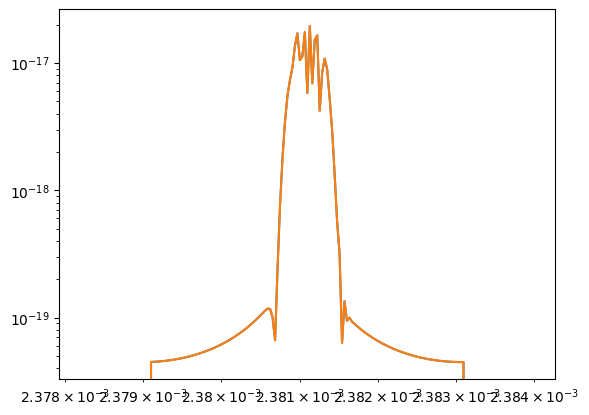

 10%|█         | 1/10 [00:01<00:17,  1.93s/it]

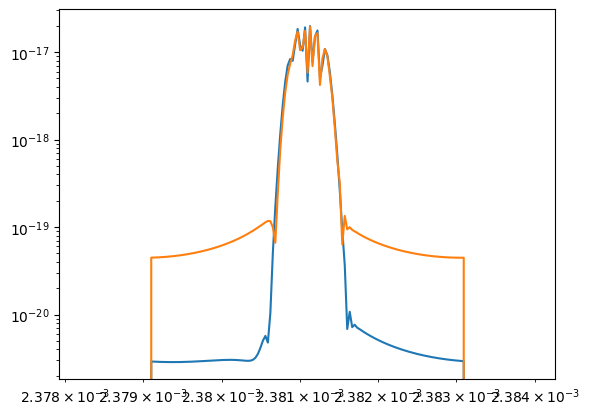

 20%|██        | 2/10 [00:03<00:15,  1.95s/it]

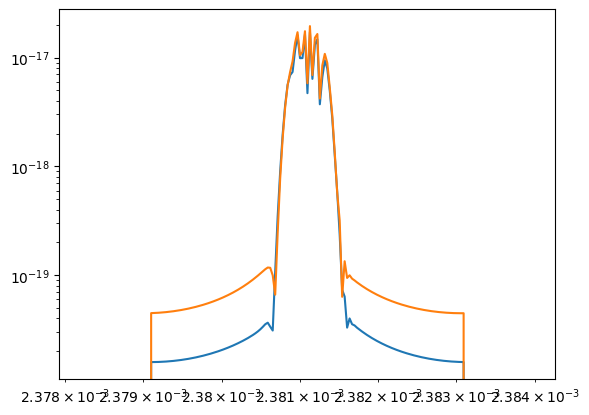

 30%|███       | 3/10 [00:05<00:13,  1.95s/it]

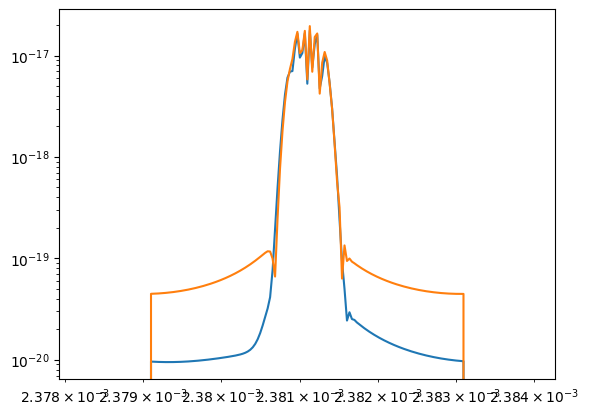

 40%|████      | 4/10 [00:07<00:11,  1.99s/it]

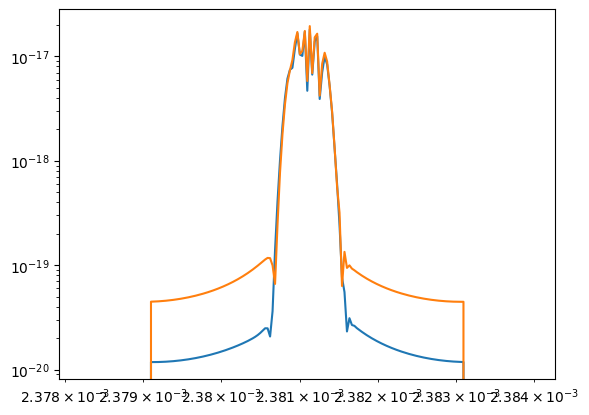

 50%|█████     | 5/10 [00:09<00:10,  2.00s/it]

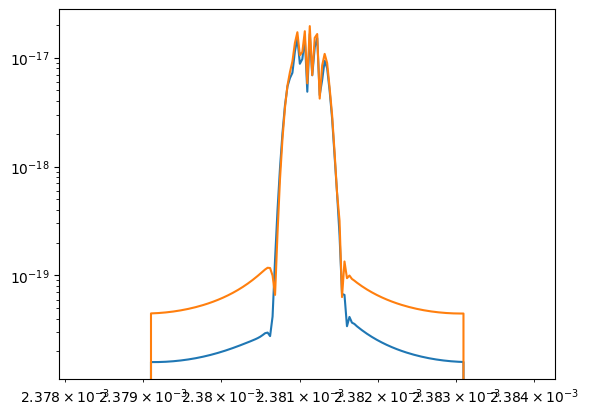

 60%|██████    | 6/10 [00:11<00:08,  2.02s/it]

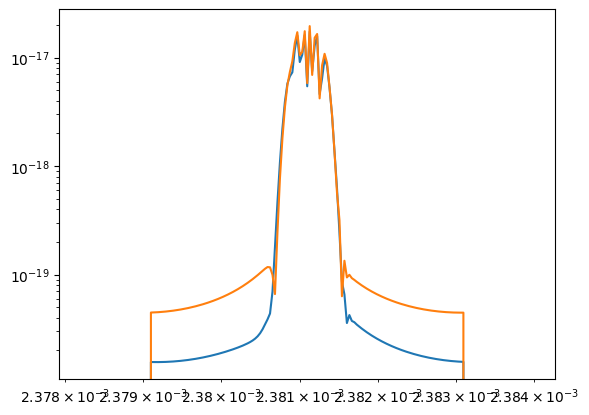

 70%|███████   | 7/10 [00:14<00:06,  2.05s/it]

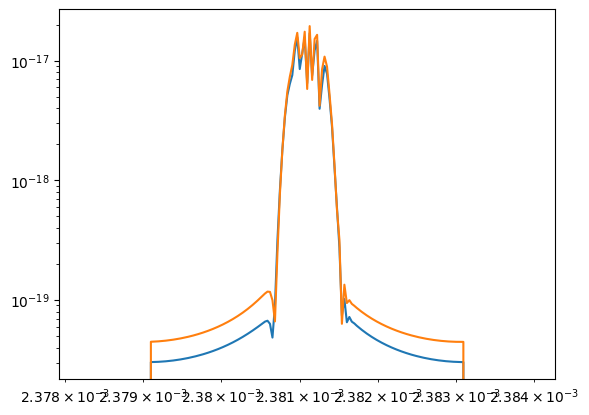

 80%|████████  | 8/10 [00:16<00:04,  2.04s/it]

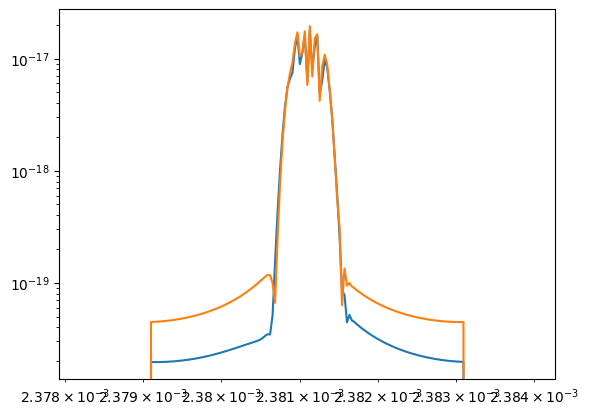

 90%|█████████ | 9/10 [00:18<00:02,  2.02s/it]

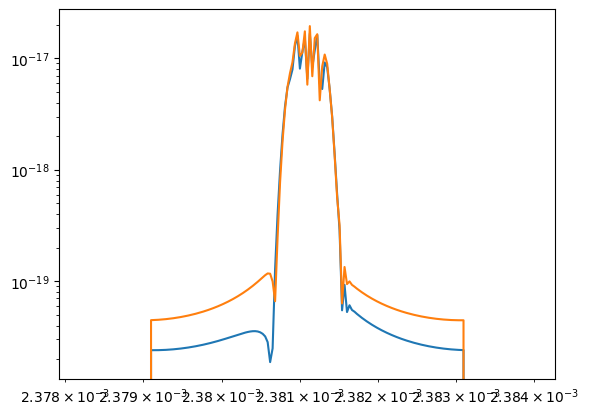

100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


In [239]:
matches = []
for i in tqdm(range(10)):
    match = compute_waveform_match(get_params(cgb.chain.iloc[i]), get_params(cgb.chain.iloc[0]))
    matches.append(match)

In [241]:
matches

[np.float64(1.0),
 np.float64(0.9587751810098225),
 np.float64(-0.039226767215945625),
 np.float64(0.11516463335092172),
 np.float64(-0.016102288123223618),
 np.float64(-0.08977512778236788),
 np.float64(-0.17664251634997974),
 np.float64(-0.19529565651771505),
 np.float64(0.4456318697922973),
 np.float64(-0.8384919285670366)]

Text(0, 0.5, 'Counts')

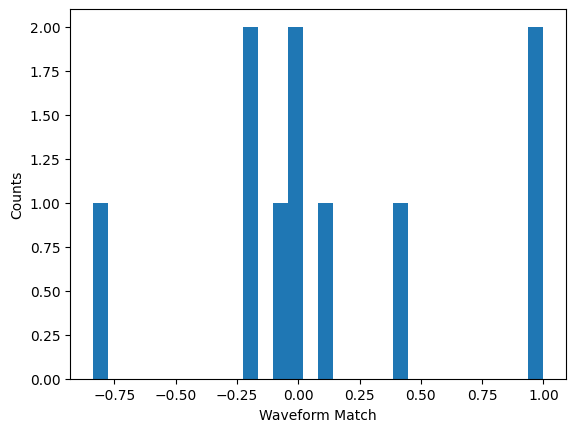

In [242]:
plt.hist(matches, bins=30)
plt.xlabel('Waveform Match')
plt.ylabel('Counts')

In [183]:
chain_matches = []
for i in tqdm(range(200)):
    match = compute_waveform_match(get_params(cgb.chain.iloc[i]), get_params(cgb.chain.iloc[0]))
    chain_matches.append(match)

100%|██████████| 200/200 [03:35<00:00,  1.08s/it]


(array([21., 14., 11.,  4.,  3.,  4.,  8.,  2.,  8.,  4.,  5.,  4.,  2.,
         5.,  4.,  8.,  7.,  7.,  5.,  5.,  7.,  7.,  2.,  8.,  3.,  3.,
        12.,  2., 10., 15.]),
 array([-0.99003048, -0.92369613, -0.85736178, -0.79102743, -0.72469308,
        -0.65835873, -0.59202438, -0.52569003, -0.45935568, -0.39302133,
        -0.32668699, -0.26035264, -0.19401829, -0.12768394, -0.06134959,
         0.00498476,  0.07131911,  0.13765346,  0.20398781,  0.27032216,
         0.33665651,  0.40299086,  0.46932521,  0.53565956,  0.6019939 ,
         0.66832825,  0.7346626 ,  0.80099695,  0.8673313 ,  0.93366565,
         1.        ]),
 <BarContainer object of 30 artists>)

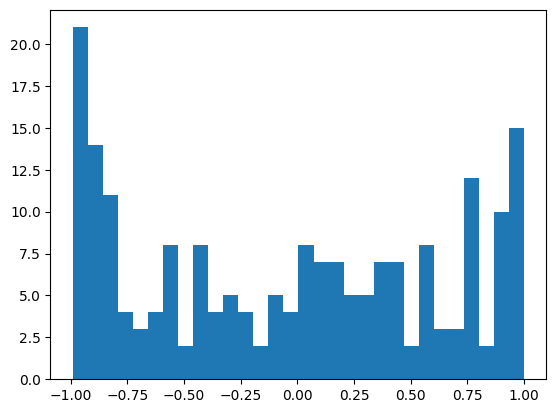

In [184]:
plt.hist(chain_matches, bins=30)

In [181]:
print(max(matches))

0.9915465976250682


In [167]:
cgb.chain.iloc[5]

Frequency               2.381099e-03
Frequency Derivative    4.992481e-17
Amplitude               4.266951e-23
Ecliptic Longitude      4.528449e+00
coslat                 -3.014709e-01
cosinc                 -7.670543e-01
Polarization            1.352946e+00
Initial Phase           5.582082e+00
SNR                     1.916790e+01
entry match             9.946620e-01
waveform measure        3.141400e+00
Ecliptic Latitude      -3.062349e-01
Inclination             2.445033e+00
Name: 5, dtype: float64

/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/corner/core.py:846: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if xs[k1] is not None:
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/corner/core.py:847: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[k1, k1].axvline(xs[k1], **kwargs)
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/corner/core.py:849: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

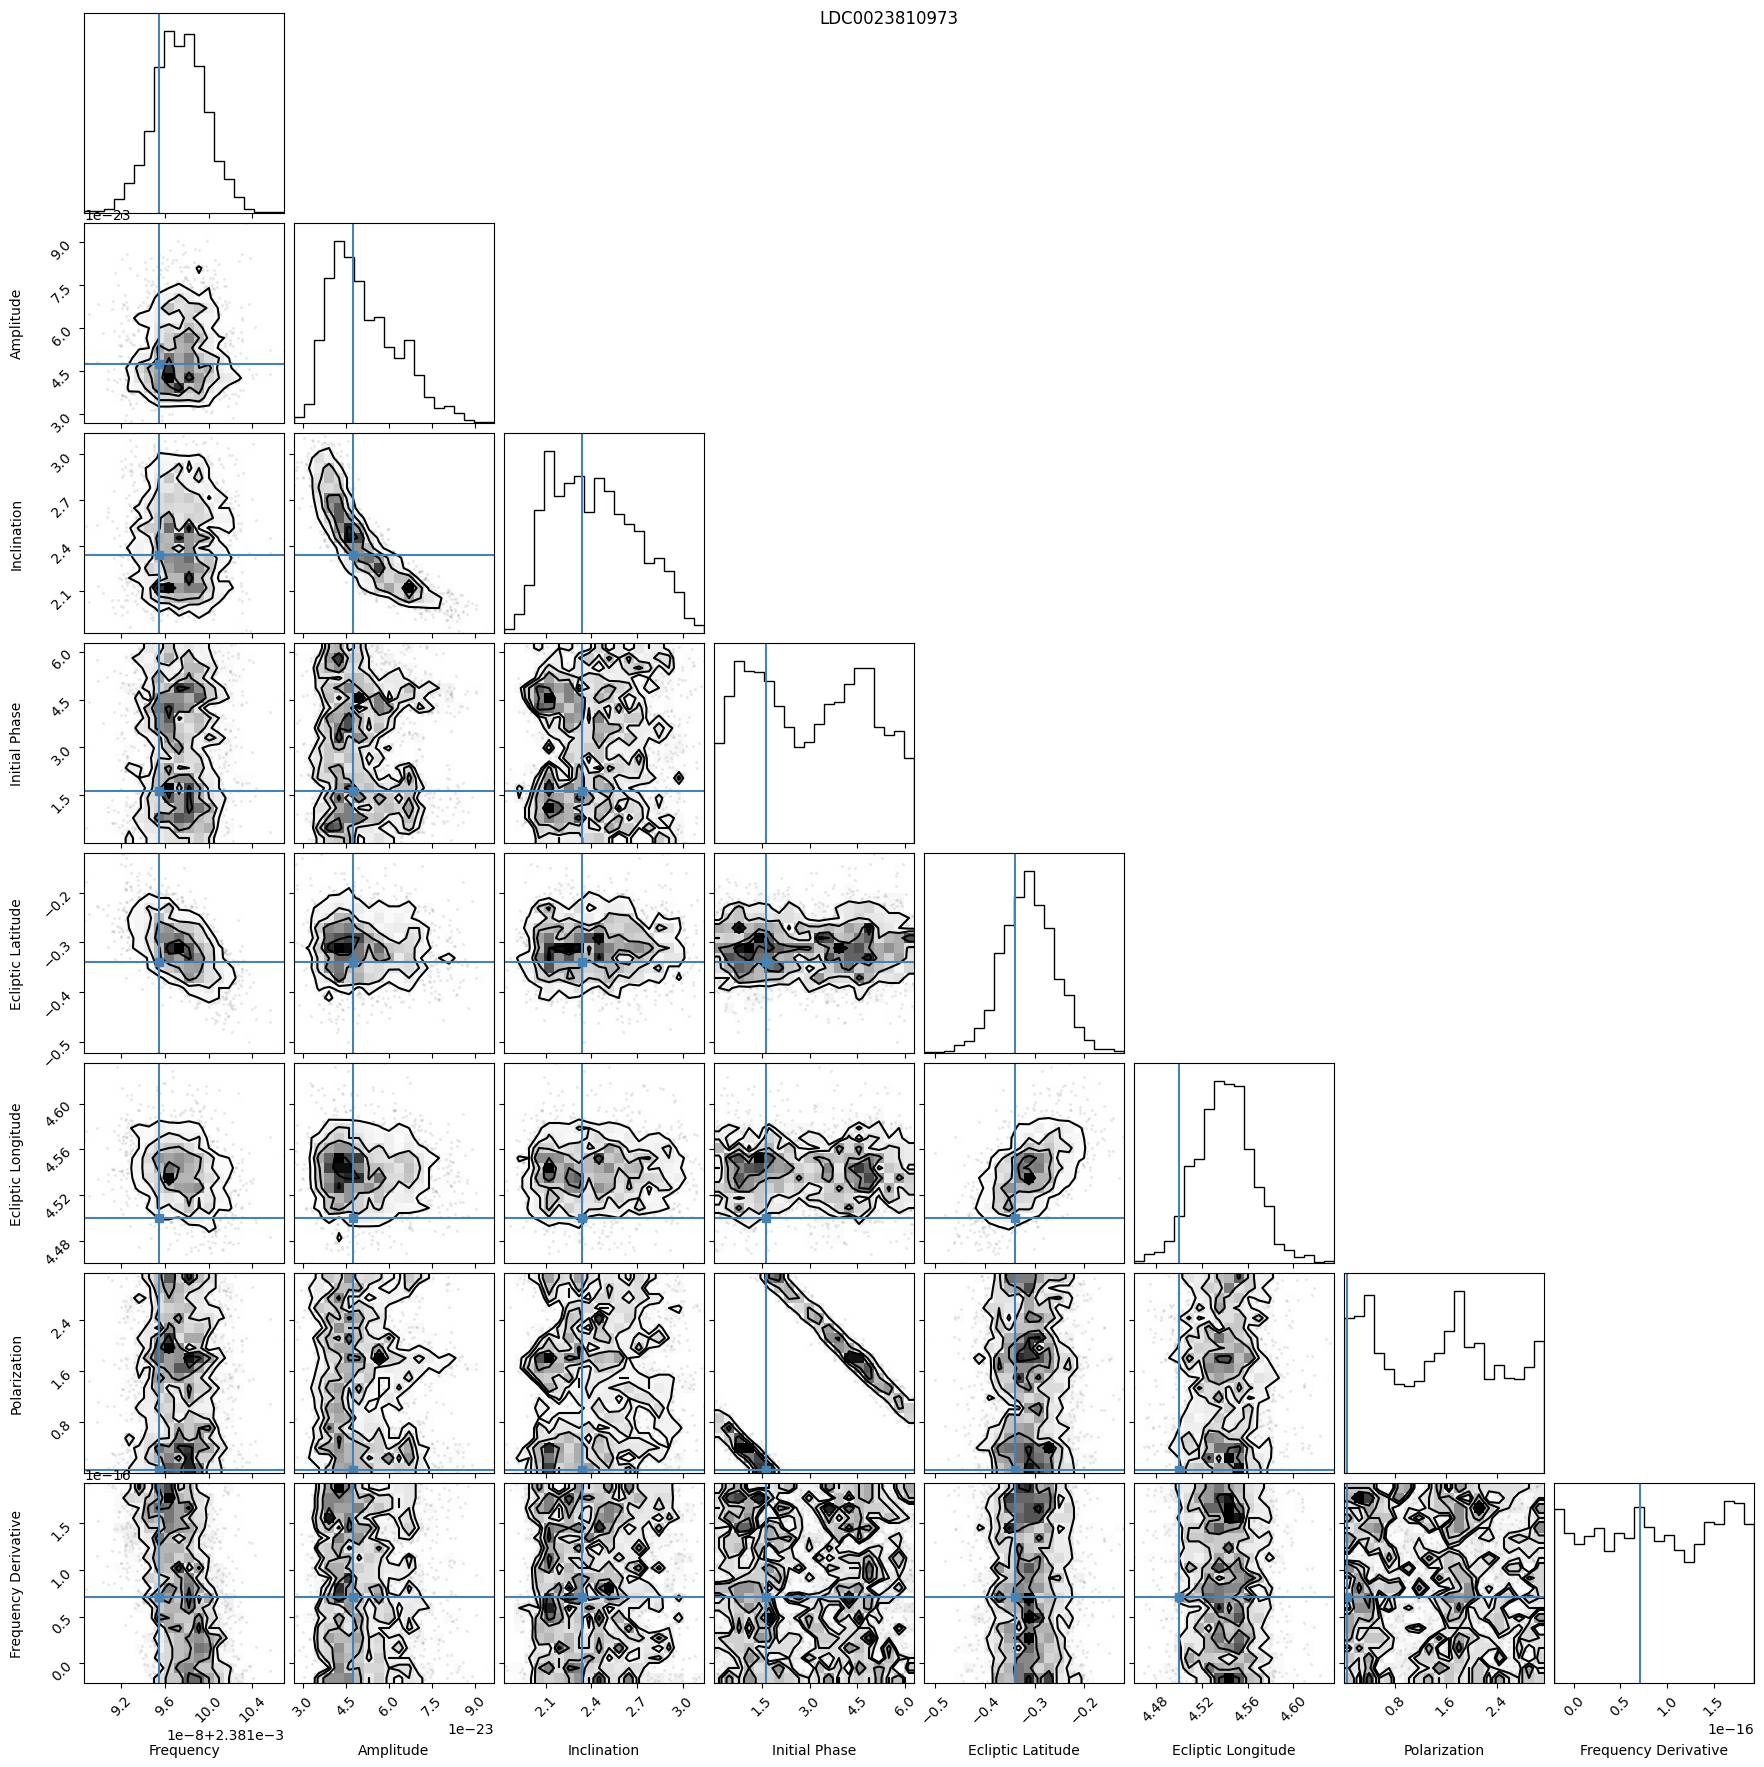

In [166]:
cgb.corner_plot(0);

In [156]:
hdrs = pd.read_feather('/Users/aaron/Documents/lisa/project-catalog/data/hdrs.feather')

In [157]:
hdrs

,Name,Candidate,SNR,Frequency HDR,Amplitude HDR,Inclination HDR,Initial Phase HDR,Ecliptic Latitude HDR,Ecliptic Longitude HDR,Polarization HDR,Frequency Derivative HDR,Sky Location HDR
0,LDC0023810973,22136087.0,153.770517,0.587680,0.309985,0.312469,0.390462,0.385991,0.902136,0.322901,0.170889,0.715847
1,LDC0041226577,11769726.0,27.754678,0.268044,0.948480,0.964261,0.920167,0.666976,0.016477,0.977953,0.596194,0.282200
2,LDC0030125413,19763412.0,10.124382,0.991817,0.957447,1.000000,0.978723,1.000000,1.000000,0.164757,0.668849,1.000000
3,LDC0030125413,18673125.0,26.663445,0.964812,0.948718,0.069285,0.193126,1.000000,1.000000,0.088652,0.640753,1.000000
4,LDC0030125413,13789765.0,7.128704,0.039007,0.076650,1.000000,0.271140,1.000000,1.000000,0.978451,0.788871,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
16319,LDC0070835742,12640258.0,127.119801,0.841024,0.257268,0.884402,0.557914,0.494693,0.825104,0.700969,0.847254,0.681587
16320,LDC0038755124,9858100.0,22.671472,0.325986,0.843583,0.906150,0.729826,0.293281,0.771774,0.015642,0.221827,0.602560
16321,LDC0099544948,23528831.0,380.056965,0.611967,0.609165,0.849310,0.325595,0.439264,0.400841,0.033620,0.513908,0.292175
16322,LDC0041193642,10348494.0,15.646238,0.349362,0.306084,0.388877,0.496968,0.879573,0.371106,0.994564,0.435919,0.692871
